# Mount Google Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import library

In [1]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential

from matplotlib import pyplot as plt

# Mendifinisikan class dan fungsi yang dibutuhkan

In [2]:
def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(os.listdir(path)):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = np.uint8)
    labels = np.array(labels, dtype = np.uint8)

    return (images, labels)

## Googlenet

In [3]:
class Inception(keras.Model):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
        super(Inception, self).__init__()

        self.path_1 = layers.Conv2D(filters_1x1, kernel_size=(1, 1), padding='same', activation='relu')
        self.path_2 = Sequential([
            layers.Conv2D(filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')
        ])
        self.path_3 = Sequential([
            layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu'),
            layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')
        ])
        self.path_4 = Sequential([
            layers.MaxPool2D((3, 3), strides=(1, 1), padding='same'),
            layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')
        ])

    def call(self, x):
        path1 = self.path_1(x)
        path2 = self.path_2(x)
        path3 = self.path_3(x)
        path4 = self.path_4(x)
        return layers.concatenate(inputs=[path1, path2, path3, path4], axis=3)

class Googlenet(keras.Model):
    def __init__(self):
        super(Googlenet, self).__init__()

        self.sequential_1 = Sequential([
            layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            layers.Conv2D(64, 1, strides=1, padding='same', activation='relu'),
            layers.Conv2D(192, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                      filters_5x5_reduce=16, filters_5x5=32, filters_pool=32),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                      filters_5x5_reduce=32, filters_5x5=96, filters_pool=64),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                      filters_5x5_reduce=16, filters_5x5=48, filters_pool=64),
        ])
        self.aux_1 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax'),
        ])
        self.sequential_2 = Sequential([
            Inception(filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64),
            Inception(filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
        ])
        self.aux_2 = Sequential([
            layers.AveragePooling2D((5, 5), strides=3),
            layers.Conv2D(128, 1, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.7),
            layers.Dense(4, activation='softmax')
        ])
        self.aux_3 = Sequential([
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            layers.MaxPooling2D(3, strides=2),
            Inception(filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128),
            Inception(filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.4),
            layers.Dense(4, activation='softmax')
        ])
    def call(self, x):
        x       = self.sequential_1(x)
        aux_1   = self.aux_1(x)
        x       = self.sequential_2(x)
        aux_2   = self.aux_2(x)
        x       = self.aux_3(x)
        return {'result':x, 'aux_1':aux_1, 'aux_2':aux_2}

## Fungsi plot history accuracy dan loss

In [4]:
def plot_history(loss, val_loss, acc, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(loss)
    axs[0].plot(val_loss)
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(acc)
    axs[1].plot(val_acc)
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Val'])

## Fungsi plot confusion matrix

In [5]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data citra original

In [10]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/train")
X_train = X_train / 255
X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/val")
X_val = X_val / 255
X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/original/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/SKRIPSI/dataset/original/train


100%|██████████| 643/643 [00:15<00:00, 40.55it/s] 


Loading /content/drive/MyDrive/SKRIPSI/dataset/original/val


100%|██████████| 80/80 [01:03<00:00,  1.25it/s]


Loading /content/drive/MyDrive/SKRIPSI/dataset/original/test


100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


## membuat model

In [12]:
model = Googlenet()

In [13]:
model.compile(optimizer='adam',
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy'])
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_val, [y_val, y_val, y_val]), batch_size=64, epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.2939 - accuracy_1: 0.2926 - accuracy_2: 0.2968 - loss: 2.3529 - sparse_categorical_crossentropy_loss: 0.4272 - val_accuracy: 0.2963 - val_accuracy_1: 0.2963 - val_accuracy_2: 0.2963 - val_loss: 2.1699 - val_sparse_categorical_crossentropy_loss: 0.4084
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.2884 - accuracy_1: 0.2998 - accuracy_2: 0.2885 - loss: 2.1832 - sparse_categorical_crossentropy_loss: 0.4093 - val_accuracy: 0.2963 - val_accuracy_1: 0.2963 - val_accuracy_2: 0.2963 - val_loss: 2.2475 - val_sparse_categorical_crossentropy_loss: 0.4718
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.3758 - accuracy_1: 0.4903 - accuracy_2: 0.4451 - loss: 1.9184 - sparse_categorical_crossentropy_loss: 0.3527 - val_accuracy: 0.6698 - val_accuracy_1: 0.7438 - val_accuracy_2: 0.7037 - val_loss: 1.1463 - val_sparse_categorical_crossentropy_loss: 0.1888
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 210m

## plot history

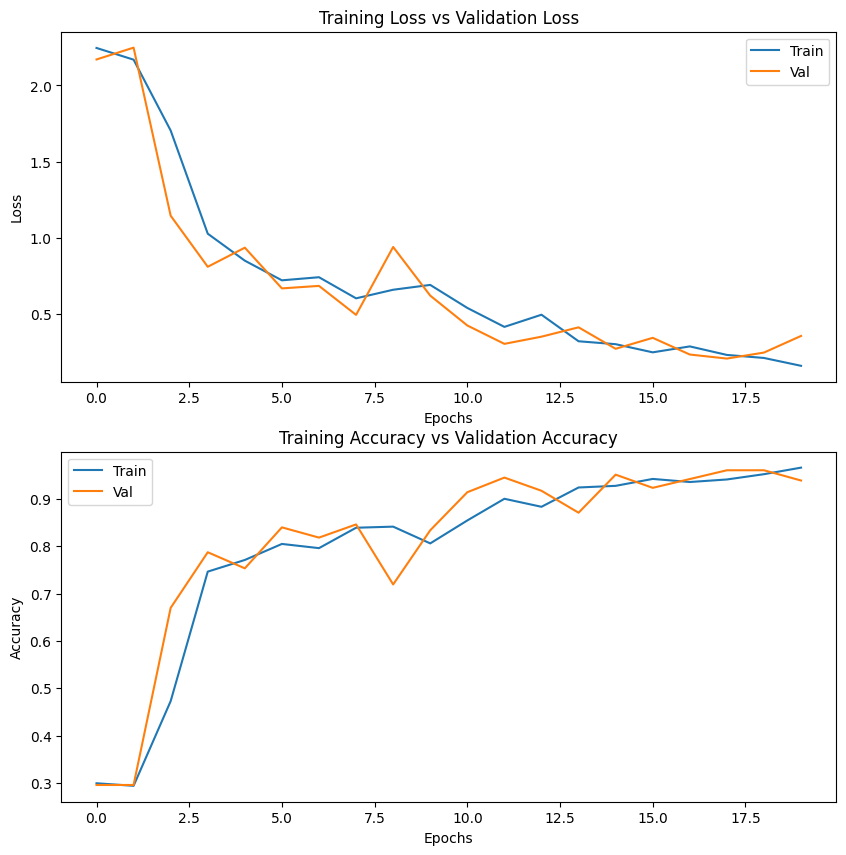

In [15]:
plot_history(history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy'])

## confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


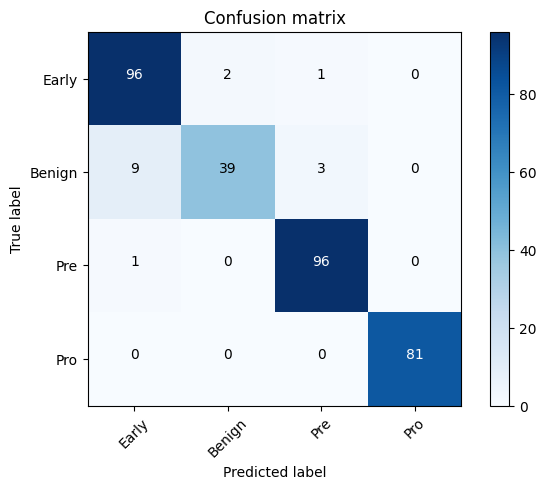

In [17]:
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred[0], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

classes = os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/original/train")

plot_confusion_matrix(cm_data.numpy(), classes)

## menyimpan model

In [18]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model", exist_ok=True)
os.makedirs("/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/original_data", exist_ok=True)

tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/streamlit/googlenet_model/original_data")

In [20]:
model

<Googlenet name=googlenet_1, built=True>

# Data citra CLAHE

In [19]:
X_train, y_train = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/train")
X_train = X_train / 255
X_val, y_val = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/val")
X_val = X_val / 255
X_test, y_test = load_data("/content/drive/MyDrive/SKRIPSI/dataset/clahe/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/train


100%|██████████| 643/643 [00:20<00:00, 31.38it/s] 


Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/val


100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


Loading /content/drive/MyDrive/SKRIPSI/dataset/clahe/test


100%|██████████| 81/81 [01:04<00:00,  1.27it/s]


## membuat model

In [ ]:
model = Googlenet()

model.compile(optimizer='adam',
    loss=[
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy,
        losses.sparse_categorical_crossentropy
    ],
    loss_weights=[1, 0.3, 0.3],
    metrics=['accuracy', 'accuracy', 'accuracy']
)
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_val, [y_val, y_val, y_val]), batch_size=64, epochs=20)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 655ms/step - accuracy: 0.3125 - accuracy_1: 0.3190 - accuracy_2: 0.3193 - loss: 7.9077 - sparse_categorical_crossentropy_loss: 0.9472 - val_accuracy: 0.7006 - val_accuracy_1: 0.7593 - val_accuracy_2: 0.7315 - val_loss: 1.1509 - val_sparse_categorical_crossentropy_loss: 0.1807
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7249 - accuracy_1: 0.7651 - accuracy_2: 0.7410 - loss: 1.0585 - sparse_categorical_crossentropy_loss: 0.1978 - val_accuracy: 0.7809 - val_accuracy_1: 0.7500 - val_accuracy_2: 0.7346 - val_loss: 0.8626 - val_sparse_categorical_crossentropy_loss: 0.1614
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.7074 - accuracy_1: 0.7310 - accuracy_2: 0.7003 - loss: 1.1134 - sparse_categorical_crossentropy_loss: 0.2079 - val_accuracy: 0.8117 - val_accuracy_1: 0.8673 - val_accuracy_2: 0.8086 - val_loss: 0.6511 - val_sparse_categorical_crossentropy_loss: 0.1041
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 18

## plot history

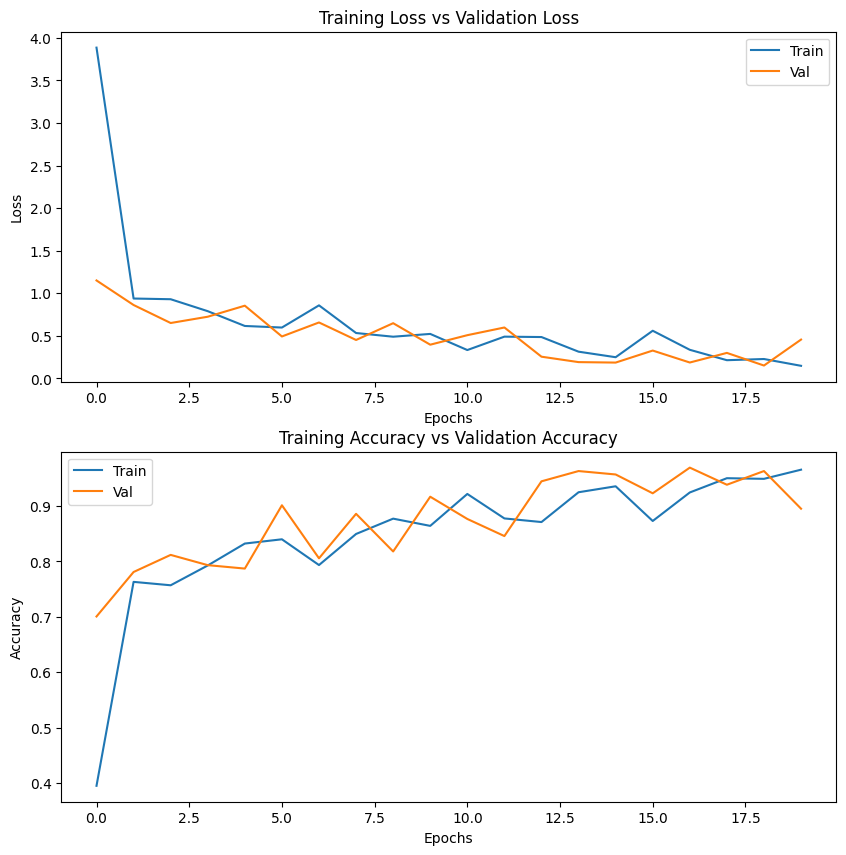

In [ ]:
plot_history(
    history.history['loss'],
    history.history['val_loss'],
    history.history['accuracy'],
    history.history['val_accuracy'])

## confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


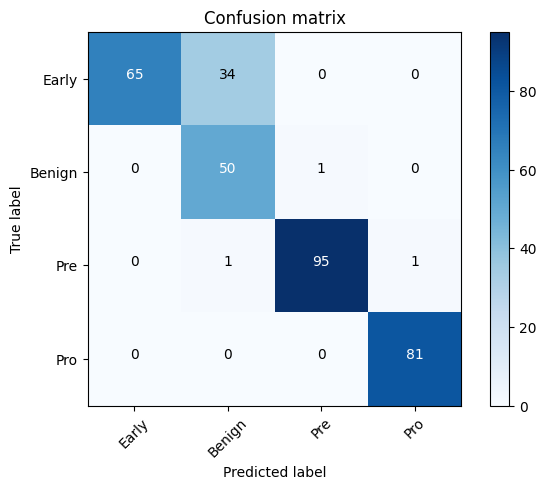

In [ ]:
y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred[0], axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred).numpy()

classes = os.listdir("/content/drive/MyDrive/SKRIPSI/dataset/original/train")

plot_confusion_matrix(cm_data, classes)

## menyimpan model

In [ ]:
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet_model", exist_ok=True)
os.makedirs("/content/drive/MyDrive/SKRIPSI/googlenet_model/clahe_data", exist_ok=True)

tf.saved_model.save(model, "/content/drive/MyDrive/SKRIPSI/googlenet_model/clahe_data")